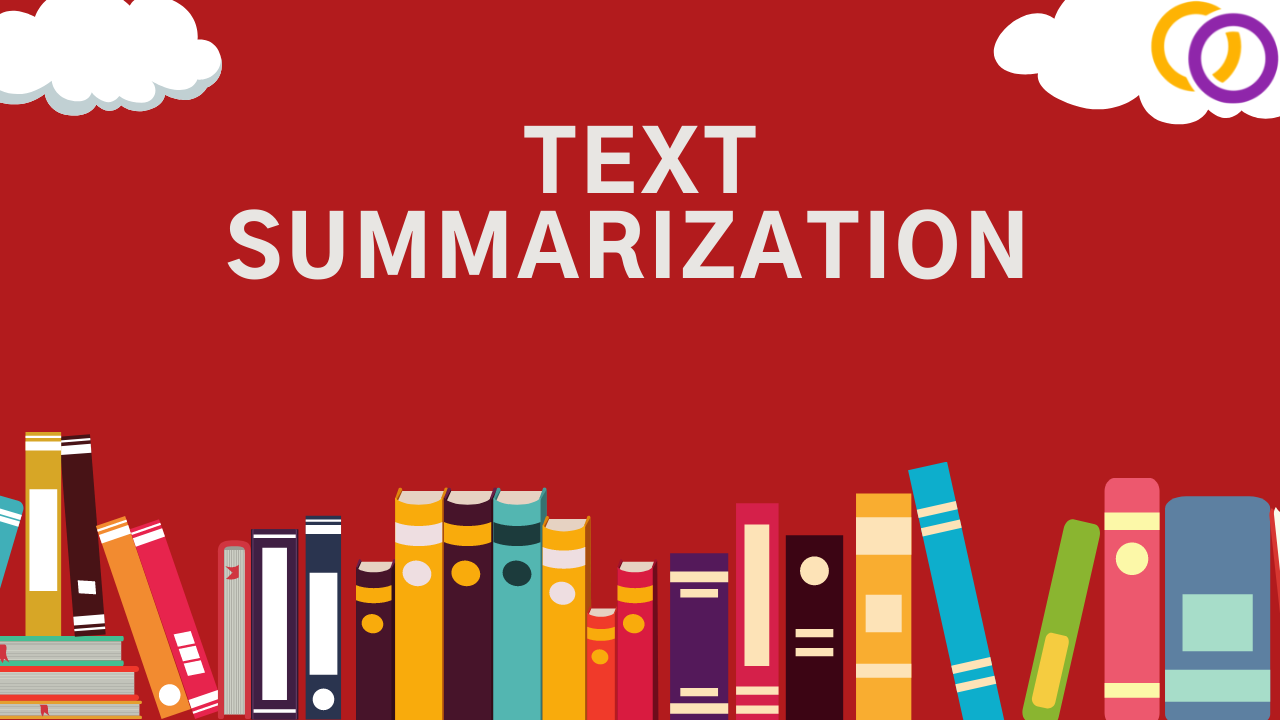

https://en.wikipedia.org/w/api.php

Text SUmmarization:

 - Abstractive Summarization
 - Extractive Summarization

In [ ]:
# !pip install transformers

In [ ]:
import requests
from transformers import AutoTokenizer

import nltk
nltk.download("stopwords")
nltk.download("punkt")
import re
import string

from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize as nltk_sent_tokenize
from nltk.tokenize import word_tokenize as nltk_word_tokenize

from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
import numpy as np
from nltk.corpus import stopwords

from scipy.spatial.distance import cosine

In [ ]:
def fetch_and_save_wiki(title):
  response = requests.get(
      "https://en.wikipedia.org/w/api.php",

      params = {
          "action":"query",
          "format" : "json",
          "titles": title,
          "prop" :"extracts",
          "explaintext": True
      }
      ).json()

  page = next(iter(response["query"]["pages"].values()))
  wiki_text = page["extract"]

  return wiki_text


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
def clean_text(text):
  text = re.sub(r'[^A-Za-z0-9\s.\(\)[\]{\}]+', '' , text)
  text = text.lower()
  text = " ".join(text.split())
  return text


def count_tokens(text):
  tokens = tokenizer.encode(text , add_special_tokens = True)
  return(len(tokens))

France Zinedine Zidane	3	—	—	3
Brazil Ronaldinho	2	—	—	2
Poland Robert Lewandowski	—	—	2	2
Germany Lothar Matthäus	1	—	—	1
Netherlands Marco van Basten	1	—	—	1
Italy Roberto Baggio	1	—	—	1
Brazil Romário	1	—	—	1
Liberia George Weah	1	—	—	1
Brazil Rivaldo	1	—	—	1
Portugal Luís Figo	1	—	—	1
Italy Fabio Cannavaro	1	—	—	1
Brazil Kaká	1	—	—	1
Croatia Luka Modrić

In [ ]:
soccar_player =[
    "Lionel Messi",
    "Cristiano Ronaldo",
    "Ronaldo",
    "Zinedine Zidane",
    "Ronaldinho",
    "Robert Lewandowski",
    "Lothar Matthäus",
    "Marco van Basten",
    "Roberto Baggio",
    "Romário",
    "George Weah",
    "Rivaldo",
    "Luís Figo",
    "Fabio Cannavaro",
    "Kaká",
    "Luka Modrić"
]

data = []

for player in soccar_player:
  info = fetch_and_save_wiki(player)
  tokens = tokenizer.encode(info , add_special_tokens = True , truncation = True , max_length = 30000)
  num_tokens = len(tokens)
  data.append([player , info , num_tokens])

In [ ]:
# data

In [ ]:
import pandas as pd


In [ ]:
df = pd.DataFrame(data , columns = ["soccar_player" , "player_information" , "num_tokens"])
df.head()

In [ ]:
df["player_information_cleaned"] = df['player_information'].apply(clean_text)

In [ ]:
df["cleaned_token_player"] = df["player_information_cleaned"].apply(count_tokens)

In [ ]:
df.head()

In [ ]:
# df.to_csv("world_soccar_player.csv")

In [ ]:
# Sentence tokenization

def sent_tokenize(text):
  sents = nltk_sent_tokenize(text)

  sent_filtered = []

  for s in sents:
    sent_filtered.append(s)
  return sent_filtered


# Clean sentence function

def cleanup_sentences(text):
  stop_words = set(stopwords.words("english"))
  sentences = sent_tokenize(text)

  sentences_cleaned = []

  for sent in sentences:
    words = nltk_word_tokenize(sent)
    words = [w for w in words if w not in string.punctuation]
    words = [w for w in words if not w.lower() in stop_words]
    words = [w.lower() for w in words]
    sentences_cleaned.append(" ".join(words))

  return sentences_cleaned


In [ ]:
df["cleaned_sentences"] = df["player_information_cleaned"].apply(cleanup_sentences)

In [ ]:
df.head()

In [ ]:
# df["cleaned_sentences"][0]

In [ ]:
# TFIDF:

def get_tf_idf(sentences):
    vectorizer = CountVectorizer()
    sent_word_matrix = vectorizer.fit_transform(sentences)

    transformer = TfidfTransformer(norm = None , sublinear_tf= False , smooth_idf = False)
    tfidf = transformer.fit_transform(sent_word_matrix)
    tfidf = tfidf.toarray()

    # Calculate the centroid vector
    centroid_vector = tfidf.sum(axis = 0)
    centroid_vector = np.divide(centroid_vector , centroid_vector.max())

    feature_names = vectorizer.get_feature_names_out()

    relevant_vector_indices = np.where(centroid_vector > 0.3)[0]

    word_list = [feature_names[idx] for idx in relevant_vector_indices]

    return word_list


In [ ]:
df["most_important_words"] = df["cleaned_sentences"].apply(get_tf_idf)

In [ ]:
df.head()

In [ ]:
# df['most_important_words'][1]

In [ ]:
import matplotlib.pyplot as plt

def plot_important_words(df, player_index):
  important_words = df['most_important_words'][player_index]
  plt.figure(figsize=(10, 6))
  plt.bar(important_words, range(len(important_words)))
  plt.xticks(rotation='vertical')
  plt.xlabel('Word')
  plt.ylabel('Frequency')
  plt.title(f"Most Important Words for {df['soccar_player'][player_index]}")
  plt.show()

# Plot the most important words for the first player
plot_important_words(df, 10)


In [ ]:
def word_vector_cache(sentences , embedding_model):
  word_vectors = dict()
  for sent in sentences:
    words = nltk_word_tokenize(sent)
    for w in words:
      word_vectors.update({w: embedding_model.wv[w]})
    return word_vectors

In [ ]:
def build_embedding_representation(words , word_vectors , embedding_model):
  embedding_representation = np.zeros(embedding_model.vector_size , dtype = 'float32')
  word_vector_key = set(word_vectors.keys())

  count = 0
  for w in words:
    if w in word_vector_key:
      embedding_representation = embedding_representation + word_vectors[w]
      count += 1

  if count !=0:
    embedding_representation = np.divide(embedding_representation , count)

  return embedding_representation


In [ ]:
def similarity(v1 , v2):
  score = 0.0
  if np.count_nonzero(v1) != 0 and np.count_nonzero(v2) != 0:
    score = ((1 - cosine(v1,v2)) + 1) / 2
  return score

In [ ]:

def summarize(text , embedding_model):
  raw_sentences = sent_tokenize(text)
  clean_sentences = cleanup_sentences(text)

  for i , s in enumerate(raw_sentences):
    print(i , s)

  for i , s in enumerate(clean_sentences):
    print(i ,s)


  centroid_words = get_tf_idf(clean_sentences)
  print(len(centroid_words) , centroid_words)

  word_vectors = word_vector_cache(clean_sentences , embedding_model)

  # Centroid embedding representation

  centroid_vectors = build_embedding_representation(centroid_words , word_vectors ,embedding_model)
  sentences_score = []

  for i in range(len(clean_sentences)):
    score = []
    words = clean_sentences[i].split()

    #sentence embedding representation
    sentence_vector = build_embedding_representation(words ,word_vectors , embedding_model )

    # Cosine similarity between sentence vector and centroid vector

    score = similarity(sentence_vector , centroid_vectors)
    sentences_score.append((i , raw_sentences[i] , score , sentence_vector))

    sentences_score_sort = sorted(sentences_score , key = lambda el: el[2] , reverse = True)

    for s in sentences_score_sort:
      print(s[0] , s[1] , s[2])

    count = 0
    sentence_summary = []

    for s in sentences_score_sort:
      if count > 100:
        break
      include_flag = True

      for ps in sentence_summary:
        sim = similarity(s[3] , ps[3])
        if sim > 0.95:
          include_flag = False

      if include_flag:
        sentence_summary.append(s)
        count += len(s[1].split())


      sentence_summary = sorted(sentence_summary , key = lambda el: el[0] , reverse = False)

    summary = "\n".join(s[1] for s in sentence_summary)
    print(summary)

    return summary

In [ ]:
df['cleaned_sentences'] = df['cleaned_sentences'].astype(str)

In [ ]:
sentences = [nltk.word_tokenize(sent) for sent in df['cleaned_sentences'].values]

In [ ]:
# sentences = [nltk.word_tokenize(sent) for sent in df['cleaned_sentences'].values]

model = Word2Vec(sentences , min_count = 1 , sg = 1)

df["summary"] = df["cleaned_sentences"].apply(lambda x:summarize(x , model))

In [ ]:
df.head()

In [ ]:
df["summary_token"] = df["summary"].apply(count_tokens)

In [ ]:
df.head()

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
import sys
sys.setrecursionlimit(1000)

rouge = Rouge()

rouge_1_score = []
rouge_2_score = []
rouge_l_score = []

for index , row in df.iterrows():
  summary = row['summary']
  player_information = row["player_information"]

  score = rouge.get_scores(summary , player_information )

  rouge_1_score = score[0]['rouge-1']['f']
  rouge_2_score = score[0]['rouge-2']['f']
  rouge_l_score = score[0]['rouge-l']['f']

  rouge_1_score.append(rouge_1_score)
  rouge_2_score.append(rouge_2_score)
  rouge_l_score.append(rouge_l_score)

